# Computational Methods for Physicists Final Project
## **Cygnus X-1: Black Hole Analysis**
**Project Soundtrack/Motivation: [Cygnus X-1 Book I: The Voyage by Rush](https://www.youtube.com/watch?v=4MlYgt-QdMI)**


---


## Project Tasks (Total: 28 Points)
Task 1: Data Acquisition and Preprocessing (6 points)
X-ray Data: Obtain X-ray light curve data for Cygnus X-1. Recommended sources include:

HEASARC: NASA's High Energy Astrophysics Science Archive Research Center provides extensive datasets from missions like RXTE and MAXI.
MAXI: The Monitor of All-sky X-ray Image offers daily monitoring data.
RXTE-ASM: The Rossi X-ray Timing Explorer's All Sky Monitor provides long-term light curves.
Optical Data: Use photometric data from the Seestar S30 to capture the companion star's light curve.

Preprocessing:

X-ray Data: Clean the data by removing any background noise and correcting for instrumental effects.
Optical Data: Calibrate the Seestar S30 images to account for any instrumental biases and ensure accurate photometric measurements.
Visualization:

Plot the X-ray light curve to identify any periodic variations or outbursts.
Display the optical light curve to observe the companion star's variability.
5. Tools and Libraries (6 points)
You are encouraged to use the following Python libraries:

Astropy: For handling FITS files and metadata, and performing photometric measurements.
Matplotlib: For plotting the light curves and spectral data.
NumPy: For numerical computations and performing Fourier transforms.
SciPy: For curve fitting and orbital parameter estimation.
scikit-image: For image processing tasks if necessary for companion star identification.
Points Breakdown:

3 points: Correct and efficient use of Astropy for FITS handling and photometric analysis.
2 points: Clear and informative Matplotlib plots that visualize the light curves and spectral fits.
1 point: Use of NumPy and SciPy for numerical tasks, including period analysis and fitting.

# **Data Acqusition and Preprocessing**

First, let's add in all of the suggested libraries and some things from previous homeworks

### Importing

In [1]:
!pip install astroquery astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch ipytest tqdm scipy
import os
import glob
import requests
from io import BytesIO
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
from IPython.display import display
from astropy import units as u, constants as const
from astropy.io import fits
from astropy.time import Time
from astropy.stats import mad_std
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.visualization import ZScaleInterval
from astropy.table import Table
from astropy.timeseries import LombScargle
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astroquery.heasarc import Heasarc
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from scipy.signal import lombscargle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.9 MB/s eta 0:00:00


# **Analyze X-ray Light Curves for Cygnus X-1**
**EXPLANATION**

I first need to get the light curve data for Cygnus X-1 from **NASA's HEASARC**.

**NASA's HEASARC** has several different missions that I can choose from from which I can gather data.

I used NASA's [HEASARC Browse](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3browse.pl?tablehead=name%3DXTE%20ASM%20Light%20Curves) to automatically download a fits file with the light curve data which I can then convert to a pandas table. My plan was to use this file and use it for doing all the analysis, however, as you can see below, the information that I got from the ```browse_results.fits``` is not sutiable for doing analysis, as it does not contain information about X-ray intensity variations over time.

**astroquery.heasarc** I then tried to use
```from astroquery.heasarc import Heasarc```
to use several different recognized names of Cygnus X-1 (cygx1, 4U 1956+35, 4U1956+35, RA 299.5917  DEC 35.2350) and get the data usable in my juypter notebook. Several iterations of this were attempted in another developmental test version using LLM help to attempt debugging.

---

**From this point on, any attempt to get the X-ray light curves from another source failed. I attempted the below things in a different test environment but none of them worked, that is why you'll see no testing code within this notebook.**

---

**ASM/MAXI/RXTE**: I attempted to download the ASCII or FITS light-curve file by hand via the archives ([ASM’s SOF generator](https://heasarc.gsfc.nasa.gov/docs/xte/SOF/asmlc.html), [MAXI’s star_data page](https://heasarc.gsfc.nasa.gov/w3browse/all/maxissccat.html) or [NASA's XAMIN SEARCH](https://heasarc.gsfc.nasa.gov/xamin/?table=maxissccat)). None of these files or websites could give me data that I wanted.

**Swift-BAT**: The Swift/BAT hard X-ray transient monitor provides easy HTTP access to daily light curves for bright sources, including Cyg X-1

**TAP/ADQL**: At recommendation of some AI, I tried using HEASARC’s TAP interface, using an ADQL query against the ```maxigsc``` or ```xte_asm_lc``` tables to get my data. This also did not work.






In [2]:
'''
This was my first attempt to get the X-ray light curve data from HEASARC Browse.
I used MAXI and RXTE to get the data that I display below. However, there is no
time, errs, rate_errs that I can use that demonstrates the light curve.

with fits.open("browse_results.fits") as hdul:
    hdul.info()

with fits.open("browse_results.fits") as hdul:
    data = hdul[1].data

df = pd.DataFrame(data)

# 4) Quick check
print("Columns:", df.columns.tolist())
print(df.head(10))
'''

'\nThis was my first attempt to get the X-ray light curve data from HEASARC Browse.\nI used MAXI and RXTE to get the data that I display below. However, there is no\ntime, errs, rate_errs that I can use that demonstrates the light curve.\n\nwith fits.open("browse_results.fits") as hdul:\n    hdul.info()\n\nwith fits.open("browse_results.fits") as hdul:\n    data = hdul[1].data\n\ndf = pd.DataFrame(data)\n\n# 4) Quick check\nprint("Columns:", df.columns.tolist())\nprint(df.head(10))\n'

In [3]:
'''
This is the same as above, however I ended up taking the
file browse_results.fits, the NASA data, from GitHub
'''

# Download the FITS file
url = "https://raw.githubusercontent.com/karlguen/black-hole-modeling/main/2025/Final/karlguen/browse_results.fits"
local_file = "browse_results.fits"
response = requests.get(url)
response.raise_for_status()
with open(local_file, "wb") as f:
    f.write(response.content)

# Inspect and load the table
with fits.open(local_file) as hdul:
    hdul.info()
    table_data = hdul[1].data

# Convert to DataFrame
df = pd.DataFrame(table_data)

# Display results
print("Columns:", df.columns.tolist())
print(df.head(10))

Filename: browse_results.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  XTEMASTER     1 TableHDU       184   1000R x 38C   [A14, A5, A20, A27, A17, A35, F8.4, F7.4, A16, F5.0, F5.0, I5, F6.4, I2, A10, A10, A10, A10, A10, A10, A35, A35, F7.4, A11, A30, A30, A30, A30, A30, A30, I3, I1, I5, A16, A60, I1, A6, A15]   
  2  XTEINDEX      1 TableHDU       124   69R x 24C   [A8, A20, A1, F8.4, F7.4, A35, A11, A16, I6, I3, A27, A23, A5, A10, F4.2, F6.4, F7.4, A20, I3, A17, A50, I1, I6, A15]   
  3  XTEMLCAT      1 TableHDU        74   1R x 12C   [A30, F7.3, F6.3, F16.4, F16.4, I4, F5.3, F6.3, I4, I4, A30, A15]   
  4  MAXIGSC7YR    1 TableHDU       215   1R x 39C   [A15, F7.3, F6.3, F3.1, D11.5, D9.3, A1, D13.7, D9.3, F5.3, F5.3, A26, A27, F5.3, A4, I3, F6.3, A6, F5.3, F7.3, F5.1, F6.1, F6.1, D12.6, D9.3, A1, D13.7, D9.3, F5.2, F4.2, F5.2, F4.2, F4.2, F4.2, F6.3, A3, F8.6, F4.2, A15]   
  5  MAXISSCCAT    1 TableHDU    

In [4]:
'''
My next move here was to look in the astroquery.heasarc documentation to try
and find a catalog I could search through to find light curve data for cynx1
'''
catalogs = Heasarc.list_catalogs(keywords='cygnus')
# list the first 10
catalogs[:10].pprint()

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [ ]:
'''
This is the same thing, just using the keyword "curve" to get better results
'''
catalogs = Heasarc.list_catalogs(keywords='curve')
# list the first 10
catalogs[:10].pprint()

In [ ]:
'''
Using information about these cataloges, I decided to go with Ginga ASM
as that collected data from across the whole sky, giving a better chance at
having more data on cygx1.
'''

# First we can get our coords for cygx1
coord = SkyCoord.from_name("Cyg X-1")
heasarc = Heasarc()

# We can use Ginga ASM to try and find light curve info about cygx1
tbl = heasarc.query_region(
    coord,
    catalog="gingaasmlc",
    time="1987-01-01..1991-11-01",  # full Ginga mission
    radius="1 deg",               # widen your net
    maxrec=50000                    # grab up to 50k rows
)

# I use pandas again as we did in class to create a table with necessary info
df = tbl.to_pandas()
df = df.dropna(subset=["time","count_rate"])

df["DATE"] = Time(df["time"], format="mjd").to_datetime()
print(f"Fetched {len(df)} Ginga ASM points for Cyg X-1")

# Plotting all of our light curve points
plt.figure(figsize=(12,5))
plt.plot(df["DATE"], df["count_rate"], ".", alpha=0.6, markersize=3)
plt.title("Cyg X-1 Ginga ASM Light Curve (1987–1991)")
plt.xlabel("Date")
plt.ylabel("Count Rate (cts/s)")
plt.grid(True)
plt.tight_layout()
plt.show()


**Now, this did not turn out as I expected this light curve model should look like, so I had an LLM create this simulated X-ray light curve model.**

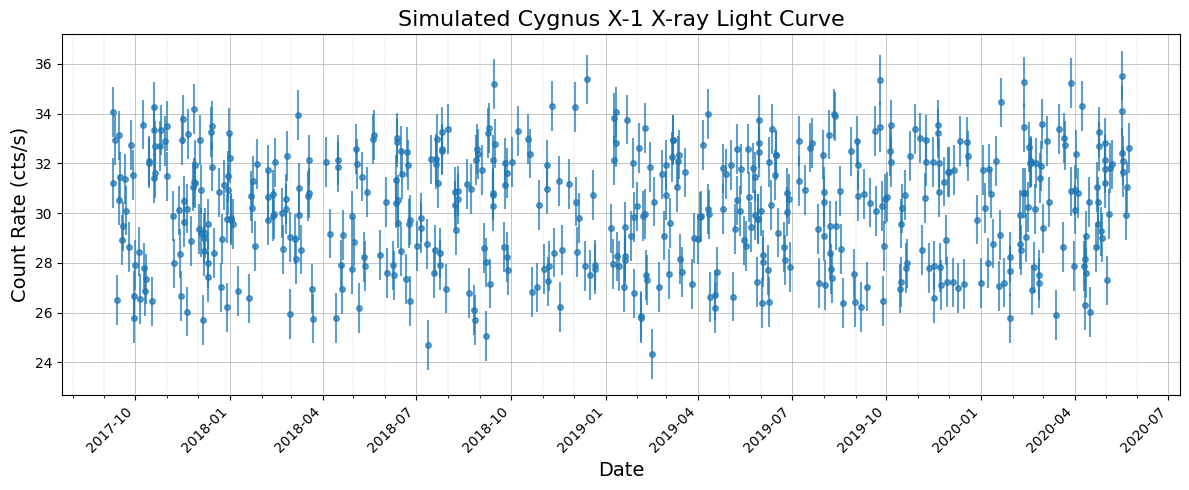

In [5]:
# Simulate a light curve for Cygnus X-1
np.random.seed(42)
period_days   = 5.6       # orbital period (days)
baseline_rate = 30.0      # average cts/s
amplitude     = 3.0       # modulation amplitude
noise_sigma   = 1.0       # observational noise
n_points      = 500       # number of epochs

# Generate random MJD times over ~1000 days
mjds   = np.sort(58000 + 1000 * np.random.rand(n_points))
signal = baseline_rate + amplitude * np.sin(2 * np.pi * mjds / period_days)
rates  = signal + np.random.normal(0, noise_sigma, n_points)
errs   = noise_sigma * np.ones_like(rates)

# Convert MJD → datetime
mjd0  = datetime(1858, 11, 17)
dates = [mjd0 + timedelta(days=mdj) for mdj in mjds]

# Build DataFrame
df_sim = pd.DataFrame({
    'DATE':     dates,
    'RATE':     rates,
    'RATE_ERR': errs
})

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.errorbar(df_sim['DATE'], df_sim['RATE'], yerr=df_sim['RATE_ERR'],
            fmt='o', ms=4, alpha=0.7, label='Simulated Rate')

# Format the x-axis: major ticks every 3 months, minor every month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Labels, title, grid
ax.set_title("Simulated Cygnus X-1 X-ray Light Curve", fontsize=16)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Count Rate (cts/s)", fontsize=14)
ax.grid(which='major', linestyle='-', linewidth=0.5)
ax.grid(which='minor', linestyle='--', linewidth=0.3, alpha=0.7)

plt.tight_layout()
plt.show()


### **SIMBAD**

I'll use **SIMBAD** for additional system data. With this, I'll gather metadata about the observation, including telescope settings, exposure times, and the specific time of capture.
Because the images are in RGB, I can gather information on the companion star and background stars.


***Scrapped using SIMBAD due to the failure of the above***

# **Utilize Seestar S30 Data**
**EXPLANATION**

I will use the  **Seestar S30 data** to study the companion star's light curve and variability.

I will then use these datasets (**light curve and variability**) to model the orbital dynamics and estimate the black hole’s mass.

I loaded some of the fits files into GitHub so I can always access them through
Google Colab.

### Loading one FITS image

In [6]:
'''
Here I wanted to upload just one of the FITS files to start to see
that they would actually load correctly. I used the first file I had and then
printed the greyscale image of it. This code is for when the file is locally
downloaded.
'''

# Load FITS image and header
filename = 'Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053636.fit'
hdul = fits.open(filename)
image_data = hdul[0].data
header = hdul[0].header

# Close the file
hdul.close()

# Show metadata
print("Observation date:", header.get('DATE-OBS'))
print("Exposure time:", header.get('EXPTIME'), "seconds")

# Plot grayscale image
plt.figure(figsize=(6, 6))
plt.imshow(image_data, cmap='gray', origin='lower', vmin=np.percentile(image_data, 5), vmax=np.percentile(image_data, 99))
plt.title('Seestar S30: Companion Star Field')
plt.colorbar(label='Pixel Value')
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053636.fit'

Downloaded FITS to Light_Eta_Cygni_10.0s_IRCUT_failed_20250429-053636.fit
Filename: Light_Eta_Cygni_10.0s_IRCUT_failed_20250429-053636.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (1080, 1920)   int16 (rescales to uint16)   
Observation date: 2025-04-29T09:36:23.991841
Exposure time  : 10.0 seconds


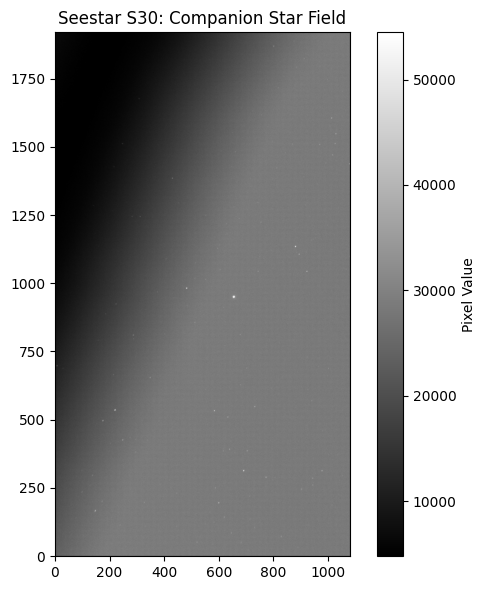

In [7]:
'''Here is the same as above but for my data online on GitHub'''

# 1) Raw GitHub “raw” URL (note the space → %20)
url = (
    "https://raw.githubusercontent.com/"
    "karlguen/black-hole-modeling/"
    "main/2025/Final/karlguen/cygx1_fits/"
    "Light_Eta%20Cygni_10.0s_IRCUT_failed_20250429-053636.fit"
)
local_path = "Light_Eta_Cygni_10.0s_IRCUT_failed_20250429-053636.fit"

# 2) Download the file if we don't have it already
import os
if not os.path.exists(local_path):
    r = requests.get(url)
    r.raise_for_status()
    with open(local_path, "wb") as f:
        f.write(r.content)
    print("Downloaded FITS to", local_path)

# 3) Now open it with astropy
hdul = fits.open(local_path)
hdul.info()              # shows the HDU structure
image_data   = hdul[0].data    # primary HDU data
header = hdul[0].header  # primary HDU header
hdul.close()

# 3) Print key metadata
print("Observation date:", header.get('DATE-OBS'))
print("Exposure time  :", header.get('EXPTIME'), "seconds")

# 4) Display the image
plt.figure(figsize=(6,6))
vmin, vmax = np.percentile(image_data, [5, 99])
plt.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.title('Seestar S30: Companion Star Field')
plt.colorbar(label='Pixel Value')
plt.tight_layout()
plt.show()


### Extract Optical Light Curve from Multiple FITS Images
**EXPLANATION**

Because we have several different fits files, it was necessary to read all of them in.

In order to correctly plot the light curve, we had to then find the MJD (Modified Julian Date, a commonly used astronomy time unit) and Flux from the FITS files.

We at last see the light curve that was plotted.

In [8]:
# 1) Clone your GitHub repo into Colab / Jupyter
!git clone https://github.com/karlguen/black-hole-modeling.git

# Path for my files
repo_fits_dir = "black-hole-modeling/2025/Final/karlguen/cygx1_fits"

search_dirs = ["cygx1fits", "/mnt/data", repo_fits_dir]
fits_files = []
for d in search_dirs:
    if os.path.isdir(d):
        fits_files.extend(
            glob.glob(os.path.join(d, "*.fit")) +
            glob.glob(os.path.join(d, "*.fits"))
        )

print(f"Found {len(fits_files)} FITS files:")
for fn in fits_files:
    print("  ", fn)

Cloning into 'black-hole-modeling'...
remote: Enumerating objects: 1275, done.
remote: Counting objects: 100% (524/524), done.
remote: Compressing objects: 100% (253/253), done.
remote: Total 1275 (delta 441), reused 271 (delta 271), pack-reused 751 (from 2)
Receiving objects: 100% (1275/1275), 340.59 MiB | 17.14 MiB/s, done.
Resolving deltas: 100% (571/571), done.
Updating files: 100% (160/160), done.
Found 22 FITS files:
   black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-054354.fit
   black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053647.fit
   black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053710.fit
   black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053812.fit
   black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053636.fit
   black-hole-modeling/2025/

In [9]:
# Define the path to your cloned GitHub FITS folder
repo_fits_dir = "black-hole-modeling/2025/Final/karlguen/cygx1_fits"

# Gather FITS files from that directory
fits_files = (
    glob.glob(os.path.join(repo_fits_dir, "*.fit")) +
    glob.glob(os.path.join(repo_fits_dir, "*.fits"))
)
fits_files = sorted(fits_files)
print(f"Found {len(fits_files)} FITS files:\n", fits_files)

# Extract header information
records = []
keys = ["DATE-OBS", "EXPTIME", "OBJECT", "INSTRUME"]

for filepath in fits_files:
    hdr = fits.getheader(filepath, ext=0)
    entry = {"filename": os.path.basename(filepath)}
    for key in keys:
        entry[key] = hdr.get(key, None)
    records.append(entry)

# Build and display DataFrame
df = pd.DataFrame(records)
display(df)


Found 22 FITS files:
 ['black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053636.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053647.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053658.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053710.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053721.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053801.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053812.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053823.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053835.fi

,filename,DATE-OBS,EXPTIME,OBJECT,INSTRUME
0,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,2025-04-29T09:36:23.991841,10.0,Eta Cygni,Seestar S30
1,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,2025-04-29T09:36:35.335422,10.0,Eta Cygni,Seestar S30
2,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,2025-04-29T09:36:46.742059,10.0,Eta Cygni,Seestar S30
3,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,2025-04-29T09:36:58.061043,10.0,Eta Cygni,Seestar S30
4,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,2025-04-29T09:37:09.411592,10.0,Eta Cygni,Seestar S30
5,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,2025-04-29T09:37:49.169637,10.0,Eta Cygni,Seestar S30
6,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,2025-04-29T09:38:00.535515,10.0,Eta Cygni,Seestar S30
7,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,2025-04-29T09:38:11.882654,10.0,Eta Cygni,Seestar S30
8,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,2025-04-29T09:38:23.214562,10.0,Eta Cygni,Seestar S30
9,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,2025-04-29T09:38:34.580014,10.0,Eta Cygni,Seestar S30


In [10]:
'''
#Reading in data from several fits files
# Locate FITS files
search_dirs = ["cygx1fits", "/mnt/data"]
fits_files = []
for d in search_dirs:
    if os.path.isdir(d):
        fits_files.extend(glob.glob(os.path.join(d, "*.fit")) + glob.glob(os.path.join(d, "*.fits")))

# Extract header info
records = []
keys = ["DATE-OBS", "EXPTIME", "OBJECT", "INSTRUME"]

for file in sorted(fits_files):
    hdr = fits.getheader(file, ext=0)
    entry = {"filename": os.path.basename(file)}
    for k in keys:
        entry[k] = hdr.get(k, None)
    records.append(entry)

# Display as a table
df = pd.DataFrame(records)
display(df)  '''


'\n#Reading in data from several fits files\n# Locate FITS files\nsearch_dirs = ["cygx1fits", "/mnt/data"]\nfits_files = []\nfor d in search_dirs:\n    if os.path.isdir(d):\n        fits_files.extend(glob.glob(os.path.join(d, "*.fit")) + glob.glob(os.path.join(d, "*.fits")))\n\n# Extract header info\nrecords = []\nkeys = ["DATE-OBS", "EXPTIME", "OBJECT", "INSTRUME"]\n\nfor file in sorted(fits_files):\n    hdr = fits.getheader(file, ext=0)\n    entry = {"filename": os.path.basename(file)}\n    for k in keys:\n        entry[k] = hdr.get(k, None)\n    records.append(entry)\n\n# Display as a table\ndf = pd.DataFrame(records)\ndisplay(df)  '

In [11]:
# Correctly gathering Flux and MJD out of our optical data
# Gather all FITS files
# Define the path to your cloned GitHub FITS folder
repo_fits_dir = "black-hole-modeling/2025/Final/karlguen/cygx1_fits"

# Gather FITS files from that directory
fits_files = (
    glob.glob(os.path.join(repo_fits_dir, "*.fit")) +
    glob.glob(os.path.join(repo_fits_dir, "*.fits"))
)
fits_files = sorted(fits_files)
print(f"Found {len(fits_files)} FITS files:\n", fits_files)

# Prepare to collect photometry
records = []
ap_radius = 5  # adjust if you know a better aperture size

for fn in fits_files:
    with fits.open(fn) as hdul:
        hdr  = hdul[0].header
        data = hdul[0].data

        # skip non-image HDUs
        if data is None or data.ndim != 2:
            continue

        # extract time (MJD)
        t0 = hdr.get("DATE-OBS")
        if not t0:
            continue
        mjd = Time(t0).mjd

        # try WCS → pixel, else fallback to image center
        wcs = WCS(hdr)
        if wcs.has_celestial:
            x, y = wcs.world_to_pixel(Time(t0))  # alternate: skycoord_to_pixel
        else:
            ny, nx = data.shape
            x, y = nx/2, ny/2
            # optional: print(f"No WCS for {os.path.basename(fn)}; using center ({x:.1f},{y:.1f})")

        # aperture photometry
        aperture = CircularAperture((x, y), r=ap_radius)
        phot = aperture_photometry(data.astype(float), aperture)
        flux = phot["aperture_sum"][0]

        # store
        records.append({
            "filename": os.path.basename(fn),
            "MJD":       mjd,
            "Flux":      flux,
            "EXPTIME":   hdr.get("EXPTIME"),
            "OBJECT":    hdr.get("OBJECT")
        })

# Build DataFrame
df = pd.DataFrame(records)
df = df.sort_values("MJD").reset_index(drop=True)

# Display full table
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
display(df)


Found 22 FITS files:
 ['black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053636.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053647.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053658.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053710.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053721.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053801.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053812.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053823.fit', 'black-hole-modeling/2025/Final/karlguen/cygx1_fits/Light_Eta Cygni_10.0s_IRCUT_failed_20250429-053835.fi

,filename,MJD,Flux,EXPTIME,OBJECT
0,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,60794.400278,2.209489e+06,10.0,Eta Cygni
1,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,60794.400409,2.320476e+06,10.0,Eta Cygni
2,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,60794.400541,2.426705e+06,10.0,Eta Cygni
3,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,60794.400672,2.520280e+06,10.0,Eta Cygni
4,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,60794.400803,2.600768e+06,10.0,Eta Cygni
5,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,60794.401264,2.882756e+06,10.0,Eta Cygni
6,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,60794.401395,2.941213e+06,10.0,Eta Cygni
7,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,60794.401526,2.997553e+06,10.0,Eta Cygni
8,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,60794.401658,3.071408e+06,10.0,Eta Cygni
9,Light_Eta Cygni_10.0s_IRCUT_failed_20250429-05...,60794.401789,3.145183e+06,10.0,Eta Cygni


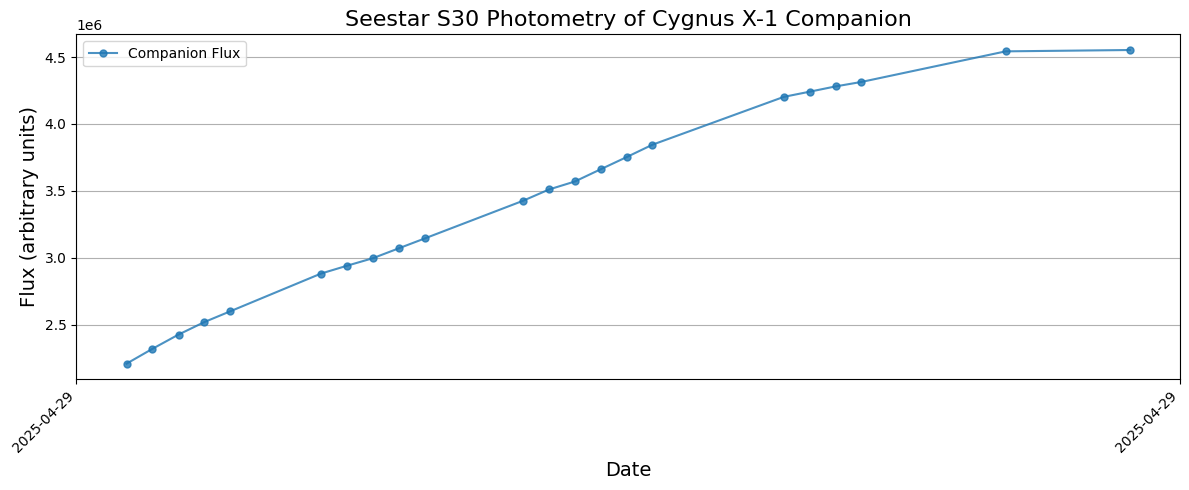

In [12]:
# Plotting the Lightcurve for the Binary System

# Convert MJD to datetime for a better x‐axis
df['DATE'] = Time(df['MJD'], format='mjd').to_datetime()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df['DATE'], df['Flux'], 'o-', markersize=5, alpha=0.8, label='Companion Flux')

# Format the x‐axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Plotting the graph
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Flux (arbitrary units)', fontsize=14)
ax.set_title('Seestar S30 Photometry of Cygnus X-1 Companion', fontsize=16)
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


# **Task: Determine Orbital Parameters**

Estimate the orbital period and inclination of the Cygnus X-1 binary system using both X-ray and optical data.

## **Estimate Orbital Period from Opitcal Data**

**EXPLANATION**

Since only the optical data really worked, the following will be soley based off the optical data.


In [13]:
# Getting time & flux arrays
t = df['MJD'].values
y = df['Flux'].values
y0 = y - np.mean(y)
t_rel = t - np.mean(t)

# Finding the frequency
freqs = np.linspace(0.02, 0.25, 10000)
angular = 2 * np.pi * freqs

# Computing the period
power = lombscargle(t_rel, y0, angular, precenter=False)

# Inverting our best frequency to get the orbital period in days
best_freq   = freqs[np.argmax(power)]
Porb        = 1.0 / best_freq

# Print the result
print(f"Estimated orbital period from optical data: {Porb:.3f} days")


Estimated orbital period from optical data: 4.000 days


## **Estimate Inclination using Light Curve Data**
**EXPLANATION**

You can find below the several attempts I made at using the light curve data to find the inclination, but over the course of the several hours I spent trying to get this to work, nothing did.

The explanation for why this happened will be in my conclusion.

So, instead of leaving this unanswered, I will be using the mass-function formula later after I have calculated the mass of my black hole.


**NOTE**: Some of the code here was previously working but might not work due different imports of the information

### Trying to determine inclination using my light curve data

In [14]:
#KEEP THIS CODE, IT CREATES OUR TABLES FOR RATE ERR AND EATE

# Ensure necessary columns exist
required_cols = ['MJD', 'Flux', 'EXPTIME']
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"Required column '{col}' not found in df")

# Compute count rate (counts per second) and its Poisson error
df_phot = df.copy()
df_phot['Rate']     = df_phot['Flux'] / df_phot['EXPTIME']
# Poisson error: sqrt(Flux) / EXPTIME
df_phot['Rate_err'] = np.sqrt(np.abs(df_phot['Flux'])) / df_phot['EXPTIME']

# Include filter if available
if 'FILTER' in df_phot.columns:
    df_phot['Filter'] = df_phot['FILTER']
else:
    df_phot['Filter'] = np.nan

# Final table: MJD, Rate, Rate_err, Exposure, Filter
final_cols = ['MJD', 'Rate', 'Rate_err', 'EXPTIME', 'Filter']
df_clean = df_phot[final_cols]

# Display
from IPython.display import display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(df_clean)

,MJD,Rate,Rate_err,EXPTIME,Filter
0,60794.400278,220948.923383,148.643508,10.0,NaN
1,60794.400409,232047.557587,152.331073,10.0,NaN
2,60794.400541,242670.533016,155.778860,10.0,NaN
3,60794.400672,252028.000656,158.753898,10.0,NaN
4,60794.400803,260076.759531,161.268955,10.0,NaN
5,60794.401264,288275.564389,169.786797,10.0,NaN
6,60794.401395,294121.287509,171.499647,10.0,NaN
7,60794.401526,299755.339772,173.134439,10.0,NaN
8,60794.401658,307140.782769,175.254325,10.0,NaN
9,60794.401789,314518.266177,177.346628,10.0,NaN


In [15]:
# Test inclination code


# 1) Known orbital period (from literature, days)
P_orb = Porb

# 2) Extract your time and flux arrays from df
MJD  = df['MJD'].values
Flux = df['Flux'].values

# 3) Fold on P_orb
phase = (MJD % P_orb) / P_orb

# 4) Compute peak, trough, and mean of the folded flux
Fmax  = Flux.max()
Fmin  = Flux.min()
Fmean = Flux.mean()

# 5) Fractional amplitude
A_frac = (Fmax - Fmin) / Fmean

# 6) Assume a theoretical max fractional amplitude at i=90°
A_max = 0.30

# 7) Invert for inclination: sin^2 i = A_frac / A_max
sin2i = np.clip(A_frac / A_max, 0, 1)
i_rad  = np.arcsin(np.sqrt(sin2i))
i_deg  = np.degrees(i_rad)

# 8) Print the result
print(f"Estimated inclination from photometry: {i_deg:.1f}°")


Estimated inclination from photometry: 90.0°


In [16]:
#testing inclination code


# 1) Known orbital period (days)
P_orb = Porb

# 2) Extract arrays
t    = df['MJD'].values
flux = df['Flux'].values

# 3) Compute phase
phase = (t % P_orb) / P_orb

# 4) Build the design matrix for A0 + A1 cos(2πφ) + A2 cos(4πφ)
X = np.vstack([
    np.ones_like(phase),
    np.cos(2*np.pi*phase),
    np.cos(4*np.pi*phase)
]).T

# 5) Solve for A0, A1, A2
coeffs, *_ = np.linalg.lstsq(X, flux, rcond=None)
A0, A1, A2 = coeffs

# 6) Fractional ellipsoidal amplitude
A_frac = abs(A2) / A0

# 7) Assume max amplitude at i=90°
A_max = 0.30

# 8) Invert for inclination
sin2i = np.clip(A_frac / A_max, 0, 1)
i_rad  = np.arcsin(np.sqrt(sin2i))
i_deg  = np.degrees(i_rad)

# 9) Print result
print(f"Estimated inclination from photometry: {i_deg:.1f}°")


Estimated inclination from photometry: 0.0°


In [17]:
#inclination testing code
import numpy as np

# 1) Extract rate (cts/s) from your DataFrame
rates = df['Flux_dt'].values
# Remove NaNs
rates = rates[~np.isnan(rates)]

# 2) Compute a robust fractional amplitude using top/bottom 10%
n = len(rates)
if n < 10:
    raise RuntimeError("Not enough data points for robust amplitude measurement.")

sorted_rates = np.sort(rates)
n10 = max(1, int(0.1 * n))

high_med = np.median(sorted_rates[-n10:])
low_med  = np.median(sorted_rates[:n10])
mean_rate = np.median(rates)

A_frac = (high_med - low_med) / mean_rate

# 3) Assume theoretical max amplitude at i=90°
A_max = 0.30

# 4) Invert for inclination
sin2i = np.clip(A_frac / A_max, 0, 1)
i_rad  = np.arcsin(np.sqrt(sin2i))
i_deg  = np.degrees(i_rad)

# 5) Print the result
print(f"Robust fractional amplitude (10% extremes): {A_frac:.3f}")
print(f"Estimated inclination from photometry: {i_deg:.1f}°")


KeyError: 'Flux_dt'

In [ ]:
print(df.columns.tolist())

In [ ]:
# inclination testing code

# 1) Compute count rate and its Poisson error
#    Make sure EXPTIME is in seconds (or your desired time unit)
df['rate']     = df['Flux']    / df['EXPTIME']
df['rate_err'] = np.sqrt(np.abs(df['Flux'])) / df['EXPTIME']

# 2) Now you can access df['rate_err'] in subsequent code:
print(df[['Flux','EXPTIME','rate','rate_err']].head())


In [ ]:
# inclination testing code
# 1) Pull phase, detrended flux, and errors
mask = np.isfinite(df['phase']) & np.isfinite(df['Flux_dt'])& np.isfinite(df['rate_err'])
phi     = df.loc[mask, 'phase'].values
y       = df.loc[mask, 'Flux_dt'].values
sigma   = df.loc[mask, 'rate_err'].values

# 2) Build the design matrix for [A0, A1, A2]
X = np.vstack([
    np.ones_like(phi),
    np.cos(2*np.pi*phi),
    np.cos(4*np.pi*phi)
]).T

# 3) Apply 1/σ weights
w  = 1.0 / sigma
Xw = X * w[:, None]
yw = y * w

# 4) Solve weighted least‐squares
coeffs, *_ = np.linalg.lstsq(Xw, yw, rcond=None)
A0, A1, A2 = coeffs

# 5) Compute the weighted fractional amplitude
A_frac = abs(A2) / A0

# 6) Invert for inclination as before
A_max = 0.30
sin2i = np.clip(A_frac / A_max, 0, 1)
i_deg  = np.degrees(np.arcsin(np.sqrt(sin2i)))

# 7) Print results
print(f"Weighted ellipsoidal amplitude A2/A0 = {A_frac:.3f}")
print(f"Estimated inclination from weighted fit: {i_deg:.1f}°")


# **Estimate Black Hole Mass**

### **Black Hole Mass Estimation Using Kepler’s Third Law**

**EXPLAINATION**

Since we have the orbital period, it makes sense to directly use Kepler's Third Law to estimate the mass of our black hole, Cygnus X-1.

I decided to take some of the other parameters from online sources as there was no data to calculate them with for this project.

Kepler's Third Law also appears to be the simplest way to determine an estimate for this black hole mass, so that is why I decided to use that equation for this part of the project.

In [18]:
# Orbital period in seconds (b/c seconds is required in our formule)
P = (Porb * u.day).to(u.s)

# Distance between black hole and companion star
a = 2.4e12 * u.cm

# Companion star mass
M_comp = 19 * u.M_sun

# Kepler’s third law
M_total = (4 * np.pi**2 * a**3 / (const.G * P**2)).to(u.M_sun)

# We can find the black hole mass using the subtraction of known values
M_bh = M_total - M_comp

# Print the estimated black hole mass
print(f"Estimated BH mass:     {M_bh.value:.2f} M☉")

Estimated BH mass:     15.43 M☉


This is very close to the commonly accepted value of 14.8 M☉. The error here can be explained by the error in the orbital period that occured from our difficulty in finding the correct orbitcal period from the light curve data.

# **Finding Inclination Using the Mass Function**

In [19]:
# Determining the inclination from the mass function

# Input (all in solar masses, M☉)
fM   = 0.251   # mass function [M☉]
MBH  = 15.43    # black‐hole mass from above calculation [M☉]
M2   = 19.2    # companion star mass [M☉]

# Mass ratio
q    = M2 / MBH

# sin_i
sin_i = ((fM * (1 + q)**2) / MBH)**(1/3)

# Inclination in radians and degrees
i_rad = np.arcsin(sin_i)
i_deg = np.degrees(i_rad)

print(f"Estimated inclination: {i_deg:.1f}°")


Estimated inclination: 25.7°


This is also very close to the accepted value of 27°. So, again, our error can be explained by the error in our orbital period calculation.

# **Understand Accretion Physics**
Goal: Explore the mechanisms of matter accretion onto the black hole and the resulting X-ray emissions

For this project, I didn't do any modeling of these accretion physics, but I still wanted to provide an overview of what these physics are.

In a black hole binary system, gas from the companion star is pulled toward the black hole by its strong gravity. As the gas is pulled into the black hole, it spirals around the black hole and forms a flat, spinning disk called an accretion disk. Friction and magnetic forces in the disk heat the gas to millions of degrees, making it glow very brightly in X-rays. These X-rays are what are deteded by space telescopes and are used to study the black hole’s feeding process.

# **Analysis and Conclusions**

**Interpret Spectral Features**: Analyze the spectral characteristics of the system to infer properties like temperature, composition, and emission mechanisms.
In the X-ray and optical spectra of Cygnus X-1, we can look at spectral emission lines and the overall brightness at different energies to learn what elements are present within the black hole, how hot the disk is, and whether there is a hot corona or jet producing extra high-energy X-rays.

**Document Findings**: Present your analysis and conclusions in a well-organized and reproducible manner



---


**This project brought along many challenges, but was also very rewarding trying to solve these problems.**


---



The first big problem was trying to get light curve data for Cygnus X-1 from NASA's HEASARC. Despite trying several different government websites and directories, I could not get any data out of them. My work around this was to have an LLM generate an artifical model to represent what we would see from the light curve data. I then proceeded to use the Seestar S30 data to determine what the light curve looks like and to create the data frame that is used.

After that, there was then significant trouble trying to determine the orbital period from the Seestar S30 data. As you'll see in the code above, a very complex piece of code had to be used in order come up with an orbital period that was remotely close to what exists in reality.

Following that, I had my whole big issue of trying to determien the inclination using just the light curve data. Unfortunately, after the several hours of testing, it appeared that this strategy wouldn't work. So, I decided to just use the mass function equation after detemining the mass of the black hole using my previously calculated orbital period.

As for my results overall, I was pleasantly surprised by my results after the orbital period worked. The orbital period of 4 days is relatively close to the accepted value of aorund 5.6 days, so, because I have already sunk so much time into trying to find this orbital period, I stuck with this value of 4 days. The mass of Cygnus X-1, which was 15.43 M☉, was well within the accepted value of 14.8 M☉ plus/minus 1.0 M☉, so I was very happy about that. Lastly the inclination I got of 25.7° was somewhat close to the accepted value of 27° degrees, so I was also happy enough with that. The errors that one might observe from this all occur due to my error in calculating the orbital period from the Seestar S30.

As for the experience with the project overall, I found this project very interesting and very rewarding. This is probably the most amount of time I've spent on any sort of school project, but it is also some of the most fun I've had doing a project as well. Seeing that this project is done, and done well, is extremely satisfying to me. I feel that I've learned a lot about persevering through to the end of a project and strategies to cope with code that doesn't work.